In [39]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from flow import *
from utils import *
import get_data as gd
import gc

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from lbn import LBN, LBNLayer

print(tf.__version__)
print(tf.config.list_physical_devices())
print()

2.13.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]



In [2]:
processor = gd.DataProcessor()
path = "/root/work/truth/signal/*npz"
processor.load_files(path)

(
    CGLMP,
    Higgs,
    LeadLep,
    LepM,
    LepP,
    NuM,
    NuP,
    MET,
    Wm,
    Wp,
    diLep,
    SubLep,
    Xi,
) = processor.files

lep_kin = processor.process_lep(LepP, LepM)
# print("lep_kin shape:", lep_kin.shape)
# print(lep_kin.head(5), end="\n")

# observed (Y)
MET_kin = processor.process_MET(MET).iloc[:, 1:3]
MET_kin = pd.concat([MET_kin, lep_kin], axis=1)
print("MET_kin shape:", MET_kin.shape)
print(MET_kin.head(3))

# interest (X)
dinu_kin = processor.process_dinu(NuP, NuM)[["nu_E", "nu_pz"]]
# print("dinu_kin shape:", dinu_kin.shape)
# print(dinu_kin.head(5), end="\n")

# dinu_kin = pd.concat([dinu_kin, lep_kin], axis=1)
print("dinu_kin shape:", dinu_kin.shape)
print(dinu_kin.head(3))
print()

del processor  # Clear the instance
del (
    CGLMP,
    Higgs,
    LeadLep,
    LepM,
    LepP,
    NuM,
    NuP,
    MET,
    Wm,
    Wp,
    diLep,
    SubLep,
    Xi,
)  # Clear the dataframes
del lep_kin
gc.collect()

['/root/work/truth/signal/CGLMP.npz', '/root/work/truth/signal/Higgs.npz', '/root/work/truth/signal/LeadLepton.npz', '/root/work/truth/signal/LeptonM.npz', '/root/work/truth/signal/LeptonP.npz', '/root/work/truth/signal/LmNu.npz', '/root/work/truth/signal/LpNu.npz', '/root/work/truth/signal/MET.npz', '/root/work/truth/signal/WmBoson.npz', '/root/work/truth/signal/WpBoson.npz', '/root/work/truth/signal/diLepton.npz', '/root/work/truth/signal/subLeadLepton.npz', '/root/work/truth/signal/xi_xyz.npz']

MET_kin shape: (2928862, 10)
       MET_px     MET_py     lep_p_E  lep_p_px   lep_p_py    lep_p_pz  \
0   21.531590  58.661363   19.465703 -5.065763  16.360542   -9.250574   
1  142.831582 -36.235636  131.817141  8.901175   2.966260  131.482766   
2   -4.344014 -53.593527   94.193734 -3.040100  49.431305   80.123430   

     lep_m_E   lep_m_px   lep_m_py   lep_m_pz  
0  12.031222  11.081455   2.673936  -3.847299  
1  66.401992 -13.096559  14.755815  63.403242  
2  26.267500   7.589698   1.67

11

In [3]:
from sklearn.preprocessing import StandardScaler

SCALAR_int = StandardScaler()
norm_var = SCALAR_int.fit_transform(dinu_kin)
dinu_kin = norm_var

SCALAR_MET = StandardScaler()
norm_var = SCALAR_MET.fit_transform(MET_kin)
MET_kin = norm_var

del norm_var

# %%
from sklearn.model_selection import train_test_split

np.random.seed(42)  # set random seed
indices_arr = np.arange(dinu_kin.shape[0], dtype="int")
indices_arr = np.random.choice(indices_arr, int(1e4))
train_indices, test_indices = train_test_split(
    indices_arr.flatten(), train_size=0.8, test_size=0.2, random_state=42
)

train_x = dinu_kin[train_indices]
test_x = dinu_kin[test_indices]
train_y = MET_kin[train_indices]
test_y = MET_kin[test_indices]

print(
    f"X (Interest)\nTraining data shape: {train_x.shape};\nTesting data shape: {test_x.shape}."
)
print(
    f"Y (Observed)\nTraining data shape: {train_y.shape};\nTesting data shape: {test_y.shape}."
)
print()

X (Interest)
Training data shape: (8000, 2);
Testing data shape: (2000, 2).
Y (Observed)
Training data shape: (8000, 10);
Testing data shape: (2000, 10).



In [11]:
def build_model(lbn=False):
    # define model
    model = keras.models.Sequential()

    # use LBN layer or not
    input_shape = (train_y.shape[-1],)
    if lbn == True:
        N_combinations = 3  # number of composite particles/rest frames
        model.add(
            LBNLayer(
                input_shape,
                N_combinations,
                boost_mode=LBN.PAIRS,
                # features=['E', 'beta', 'eta', 'gamma', 'm', 'p', 'pair_cos', 'pair_dr', 'pair_ds', 'pair_dy', 'phi', 'pt', 'px', 'py', 'pz']
                features=["px", "py", "pz", "E", "pt", "eta",  "phi", "m"],
            )
        )
        print("Use LBN layer...")
    else:
        model.add(layers.Flatten(input_shape=input_shape))
        print("Not using LBN layer...")

    # Simple DNN hidden layers
    # model.add(layers.Dense(units=128, activation="relu"))
    # model.add(layers.Dense(units=128, activation="relu"))
    # model.add(layers.Dense(units=128, activation="relu"))
    # model.add(layers.Dense(units=128, activation="relu"))
    model.add(layers.Dense(units=256, activation="relu"))
    model.add(layers.Dense(units=256, activation="relu"))
    model.add(layers.Dense(units=32, activation="relu"))

    # Last dense layer
    model.add(layers.Dense(units=1, activation="linear"))

    # Compile model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss="mse")
    model.summary()

    return model

In [ ]:
model = build_model(lbn=False)

In [28]:
# Fit the model
history = model.fit(
    x=train_y,
    y=train_x[:, 0],
    epochs=4028,
    batch_size=32,
    verbose=2,
)

Epoch 1/4028
250/250 - 1s - loss: 0.0316 - 645ms/epoch - 3ms/step
Epoch 2/4028
250/250 - 1s - loss: 0.0304 - 618ms/epoch - 2ms/step
Epoch 3/4028
250/250 - 1s - loss: 0.0337 - 619ms/epoch - 2ms/step
Epoch 4/4028
250/250 - 1s - loss: 0.0324 - 615ms/epoch - 2ms/step
Epoch 5/4028
250/250 - 1s - loss: 0.0374 - 619ms/epoch - 2ms/step
Epoch 6/4028
250/250 - 1s - loss: 0.0375 - 606ms/epoch - 2ms/step
Epoch 7/4028
250/250 - 1s - loss: 0.0261 - 587ms/epoch - 2ms/step
Epoch 8/4028
250/250 - 1s - loss: 0.0280 - 613ms/epoch - 2ms/step
Epoch 9/4028
250/250 - 1s - loss: 0.0234 - 622ms/epoch - 2ms/step
Epoch 10/4028
250/250 - 1s - loss: 0.0243 - 606ms/epoch - 2ms/step
Epoch 11/4028
250/250 - 1s - loss: 0.0287 - 608ms/epoch - 2ms/step
Epoch 12/4028
250/250 - 1s - loss: 0.0315 - 615ms/epoch - 2ms/step
Epoch 13/4028
250/250 - 1s - loss: 0.0310 - 633ms/epoch - 3ms/step
Epoch 14/4028
250/250 - 1s - loss: 0.0275 - 606ms/epoch - 2ms/step
Epoch 15/4028
250/250 - 1s - loss: 0.0318 - 606ms/epoch - 2ms/step
Epoc

In [33]:
x_pred = model.predict(test_y)

63/63 [==============================] - 0s 1ms/step


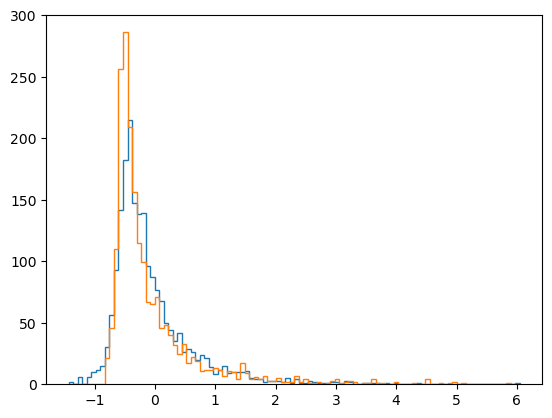

In [38]:
_, bins, _ = plt.hist(x_pred[:,0], bins=100, histtype='step')
plt.hist(E_truth, bins=bins, histtype='step')
plt.show()

In [36]:
x_pred = model.predict(test_y)
# pz_pred = x_pred[:, 1]
E_pred = x_pred[:, 0]
# pz_truth = test_x[:, 1]
E_truth = test_x[:, 0]

63/63 [==============================] - 0s 1ms/step


In [37]:
def plot_loss_history(history):
    fig = plt.figure(figsize=(8, 5), dpi=120)
    plt.plot(history.history["loss"], lw=2.5, label="Train", alpha=0.8)
    # plt.plot(history.history["val_loss"], lw=2.5, label="Validation", alpha=0.8)
    # plt.semilogy()
    plt.title("Epoch vs MSE")
    plt.xlabel("epoch")
    plt.ylabel("Loss (MSE)")
    plt.legend(loc="best")
    plt.savefig("DNN_loss.png")
    plt.show()
    plt.close()


def plot_2d_histogram(pred, truth, title, save_name, bins=100):
    hist, xedges, yedges = np.histogram2d(pred.flatten(), truth, bins=(bins, bins))
    hist = np.ma.masked_where(hist == 0, hist)
    fig = plt.figure(figsize=(6, 6), dpi=120)
    plt.pcolormesh(xedges, yedges, hist.T, cmap="viridis")
    cbar = plt.colorbar()
    cbar.set_label("Frequency")
    plt.title(title)
    plt.xlabel("Prediction")
    plt.ylabel("Truth")
    plt.savefig(save_name)
    plt.axis("equal")
    plt.show()
    plt.close()

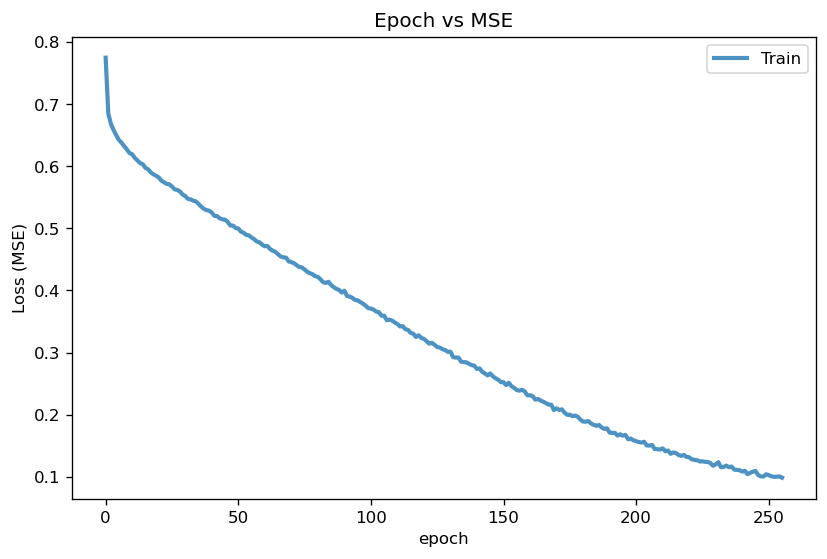

pz -> Pearson coeff: 0.571
E  -> Pearson coeff: 0.348


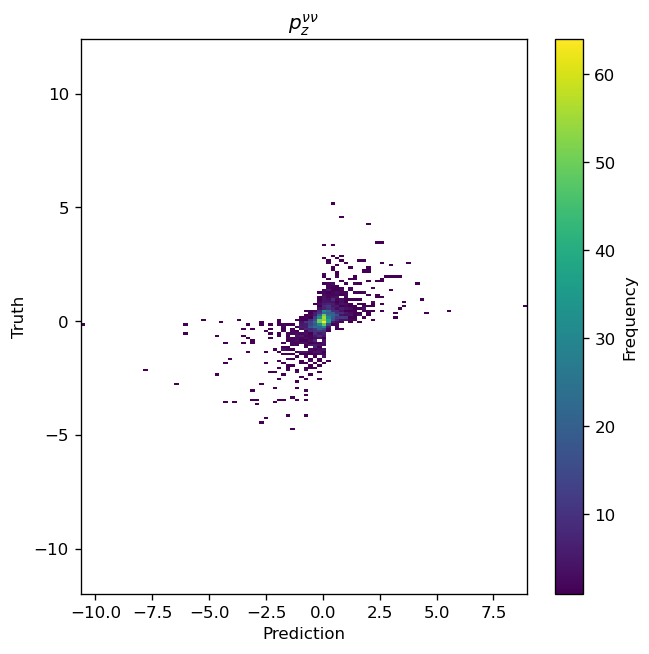

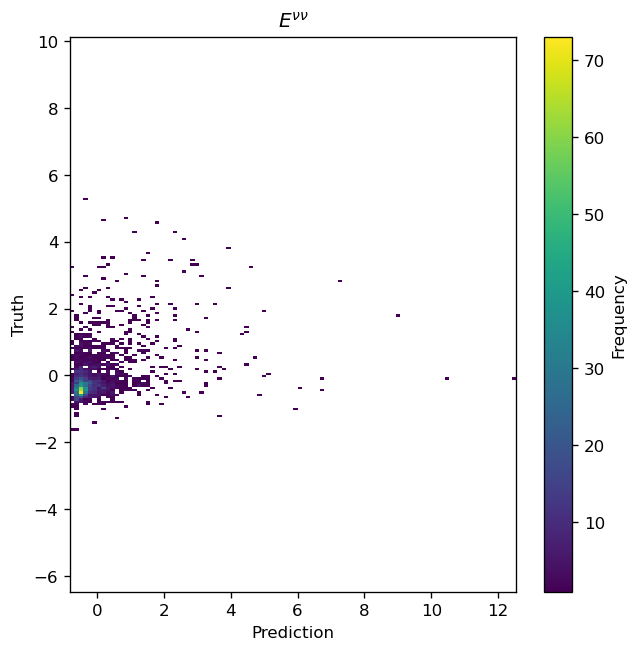

====================== Finished!! ======================


In [ ]:
import scipy as sp
plot_loss_history(history)
print(f"pz -> Pearson coeff: {sp.stats.pearsonr(pz_truth, pz_pred)[0]:.3f}")
print(f"E  -> Pearson coeff: {sp.stats.pearsonr(E_truth, E_pred)[0]:.3f}")
plot_2d_histogram(pz_truth, pz_pred, r"$p^{\nu\nu}_{z}$", save_name="DNN_pz.png")
plot_2d_histogram(E_truth, E_pred, r"$E^{\nu\nu}$", save_name="DNN_energy.png")

print("====================== Finished!! ======================")
